# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

Pseudo Labeling編

## ライブラリインポート

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import lightgbm as lgb
from optuna.integration import lightgbm as lgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## データ読み込み・前処理

In [16]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_p1.csv')

# poutcome の前処理済みファイルを使う
#train_df = pd.read_csv('y_train-Copy1.csv')
#test_df = pd.read_csv('y_test-Copy1.csv')
#train2_df = pd.read_csv('y_train-Copy2.csv')
#test2_df = pd.read_csv('y_test-Copy2.csv')
#train3_df = pd.read_csv('y_train-Copy3.csv')
#test3_df = pd.read_csv('y_test-Copy3.csv')

submit_df = pd.read_csv('submit_sample.csv', header=None)

In [17]:
print(train_df.shape)
print(test_df.shape)

(27100, 18)
(18050, 17)


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27100 non-null  int64 
 1   age        27100 non-null  int64 
 2   job        27100 non-null  object
 3   marital    27100 non-null  object
 4   education  27100 non-null  object
 5   default    27100 non-null  object
 6   balance    27100 non-null  int64 
 7   housing    27100 non-null  object
 8   loan       27100 non-null  object
 9   contact    27100 non-null  object
 10  day        27100 non-null  int64 
 11  month      27100 non-null  object
 12  duration   27100 non-null  int64 
 13  campaign   27100 non-null  int64 
 14  pdays      27100 non-null  int64 
 15  previous   27100 non-null  int64 
 16  poutcome   27100 non-null  object
 17  y          27100 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18050 entries, 0 to 18049
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        18050 non-null  int64  
 1   job        18050 non-null  int64  
 2   marital    18050 non-null  int64  
 3   education  18050 non-null  int64  
 4   balance    18050 non-null  int64  
 5   housing    18050 non-null  int64  
 6   loan       18050 non-null  int64  
 7   contact    18050 non-null  int64  
 8   day        18050 non-null  int64  
 9   month      18050 non-null  int64  
 10  duration   18050 non-null  int64  
 11  campaign   18050 non-null  int64  
 12  pdays      18050 non-null  int64  
 13  previous   18050 non-null  int64  
 14  poutcome   18050 non-null  int64  
 15  days       18050 non-null  int64  
 16  y          18050 non-null  float64
dtypes: float64(1), int64(16)
memory usage: 2.3 MB


In [20]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.700443,229.325387,1.775830,432.482399,0.085720,0.077934
std,7823.240484,7.816417,31650.760036,8.576252,204.939958,0.950045,252.150648,0.365889,0.268072
min,0.000000,22.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6774.750000,31.000000,20015.750000,8.000000,121.000000,1.000000,214.000000,0.000000,0.000000
50%,13549.500000,33.000000,47624.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.250000,37.000000,75330.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [21]:
test_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,days,y
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,47158.451801,0.577175,0.128587,0.783989,16.697950,5.998726,229.315014,1.770083,436.171801,0.090859,1.858061,168.471468,0.078112
std,7.863805,2.650421,0.873514,0.717774,31469.525699,0.494022,0.334752,0.504881,8.580203,2.118452,208.796946,0.944872,251.392519,0.375801,0.464028,64.614438,0.120539
min,20.000000,1.000000,0.000000,0.000000,-6838.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,3.000000,0.000979
25%,31.000000,3.000000,0.000000,2.000000,19654.500000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,219.250000,0.000000,2.000000,136.000000,0.013720
50%,33.000000,5.000000,2.000000,2.000000,46886.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,436.000000,0.000000,2.000000,148.000000,0.037418
75%,37.000000,7.000000,2.000000,2.000000,74178.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,654.000000,0.000000,2.000000,199.000000,0.090621
max,90.000000,12.000000,2.000000,3.000000,102124.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,4.000000,870.000000,3.000000,3.000000,336.000000,0.985538


In [22]:
train_df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [23]:
test_df.isnull().any()

age          False
job          False
marital      False
education    False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
days         False
y            False
dtype: bool

In [24]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [25]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df]

#train_df['poutcome'] = (train_df['poutcome'] + train2_df['poutcome'] + train3_df['poutcome']) / 3
#test_df['poutcome'] = (test_df['poutcome'] + test2_df['poutcome'] + test3_df['poutcome']) / 3

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

for df in df_list:
    #df['job'] = job_encoder.transform(df['job'])
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})

    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 0})
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j').astype('uint16')
    #df['days'] = df['month'] * 31 + df['day']
    
    #df['duration'] = np.log(df['duration'] + 1)
    
    df.drop(['id'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        27100 non-null  int64 
 1   job        27100 non-null  int64 
 2   marital    27100 non-null  int64 
 3   education  27100 non-null  int64 
 4   balance    27100 non-null  int64 
 5   housing    27100 non-null  int64 
 6   loan       27100 non-null  int64 
 7   contact    27100 non-null  int64 
 8   day        27100 non-null  int64 
 9   month      27100 non-null  int64 
 10  duration   27100 non-null  int64 
 11  campaign   27100 non-null  int64 
 12  pdays      27100 non-null  int64 
 13  previous   27100 non-null  int64 
 14  poutcome   27100 non-null  int64 
 15  y          27100 non-null  int64 
 16  days       27100 non-null  uint16
dtypes: int64(16), uint16(1)
memory usage: 3.4 MB


In [27]:
train_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,days
0,31,4,2,2,12294,1,0,1,21,11,101,3,498,0,0,0,326
1,29,5,0,3,43027,0,0,1,22,8,158,2,702,0,2,1,235
2,35,7,2,3,12252,1,0,1,11,11,351,1,826,0,1,0,316
3,31,2,2,2,99121,1,1,0,16,5,658,2,120,0,1,0,137
4,48,10,2,1,42005,1,0,2,3,4,177,1,273,0,2,0,94


In [28]:
test_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,days,y
0,35,2,0,2,89043,0,0,1,7,2,101,2,184,2,3,38,0.737622
1,37,4,2,2,64372,1,0,1,7,7,158,3,241,0,2,189,0.105516
2,31,4,0,2,31606,1,0,0,15,5,152,2,47,0,2,136,0.022290
3,31,6,2,2,94826,1,0,1,27,5,345,2,490,0,2,148,0.002512
4,32,4,2,2,100401,0,0,1,7,1,126,1,686,0,0,7,0.035520


In [29]:
pseudo_df = pd.concat([train_df, test_df])

In [30]:
pseudo_df.shape

(45150, 17)

In [31]:
pseudo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45150 non-null  int64  
 1   job        45150 non-null  int64  
 2   marital    45150 non-null  int64  
 3   education  45150 non-null  int64  
 4   balance    45150 non-null  int64  
 5   housing    45150 non-null  int64  
 6   loan       45150 non-null  int64  
 7   contact    45150 non-null  int64  
 8   day        45150 non-null  int64  
 9   month      45150 non-null  int64  
 10  duration   45150 non-null  int64  
 11  campaign   45150 non-null  int64  
 12  pdays      45150 non-null  int64  
 13  previous   45150 non-null  int64  
 14  poutcome   45150 non-null  int64  
 15  y          45150 non-null  float64
 16  days       45150 non-null  int64  
dtypes: float64(1), int64(16)
memory usage: 6.2 MB


## 学習準備

In [32]:
y = pseudo_df.pop('y')

X_train, X_test, y_train, y_test = train_test_split(pseudo_df, y, test_size=0.2, random_state=77)

train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)
final_train_set = lgb.Dataset(data=pseudo_df, label=y, free_raw_data=False)

## ハイパーパラメータ

In [33]:
lgb_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    #'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    #'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    #'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    #'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    #'drop_rate': 0.15
}

## 学習

In [34]:
evaluation_results = {}

clf = lgb.train(
    train_set=train_data,
    params=lgb_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=1000,
    verbose_eval=0
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)

min_data_in_leaf, val_score: 0.676459: 100%|##########| 5/5 [00:12<00:00,  2.42s/it]


Result:
{'boosting': 'dart', 'application': 'binary', 'metric': 'binary_logloss', 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 3, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('binary_logloss', 0.6730607355476843)]), 'Test': OrderedDict([('binary_logloss', 0.6764592422644676)])})


## 可視化

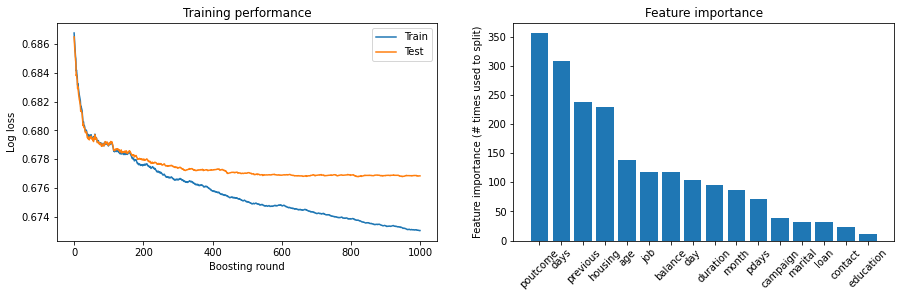

In [35]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
axs[0].set_ylabel('Log loss')
axs[0].set_xlabel('Boosting round')
axs[0].set_title('Training performance')
axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [36]:
importances.sort_values('importance')

,features,importance
3,education,11
7,contact,23
2,marital,32
6,loan,32
11,campaign,39
12,pdays,71
9,month,87
10,duration,95
8,day,104
1,job,117


In [39]:
#preds = np.round(clf.predict(X_test))
#print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
#print('Precision score = \t {}'.format(precision_score(y_test, preds)))
#print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
#print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

## 推論

In [40]:
test_df.drop(['y'], axis=1, inplace=True)
test_pred = clf.predict(test_df, num_iteration=optimum_boost_rounds)

In [41]:
submit_df[1] = test_pred
submit_df.to_csv('submit.csv', header=False, index=False)

In [42]:
#pseudo labeling

test_df['y'] = test_pred
test_df.to_csv('test_p1.csv', index=False)